In [1]:
import torch
torch.backends.cudnn.benchmark=True

import os
from datetime import datetime
import time

from loss import *
from dataset import *
from model import *
from model_resnetyolo import *
from viz import *
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

## some parameters

In [2]:
C=20
B=2
S=7
batch_size = 4
learning_rate = 2e-5
epochs = 120

# need more augmentation!

In [3]:
# https://albumentations.ai/docs/api_reference/augmentations/transforms/
# https://albumentations.ai/docs/api_reference/augmentations/geometric/transforms/
# https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
transform_aug = A.Compose([
    A.Resize(448, 448),
    A.HorizontalFlip(),
    A.ColorJitter(brightness=0.2, contrast=0., saturation=0.2, hue=0.15),
    A.Affine(scale=(1.0,1.2),translate_percent=(-0.2,0.2)),
    A.Normalize(), # mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    ToTensorV2()
], bbox_params=A.BboxParams(format='albumentations', min_visibility=0.3))

transform = A.Compose([
    A.Resize(448, 448),
    A.Normalize(), # mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    ToTensorV2()
], bbox_params=A.BboxParams(format='albumentations')) # format=albumentations is normalized pascal_voc.


train_dataset=VOCDataset(root='data', image_set='train', S=S,C=C,transform=transform_aug)
test_dataset=VOCDataset(root='data', image_set='val',  S=S,C=C,transform=transform)

train_loader=DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
test_loader=DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)


Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar
Extracting data/VOCtrainval_11-May-2012.tar to data
Using downloaded and verified file: data/VOCtrainval_06-Nov-2007.tar
Extracting data/VOCtrainval_06-Nov-2007.tar to data


In [4]:
# net = Yolov1(split_size=S, num_boxes=B, num_classes=C).cuda()
net = YOLOv1ResNet(S=S, B=B, C=C).cuda()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
loss_fn = YoloLoss(S=S, B=B, C=C)

In [5]:
# net.load_state_dict(torch.load('backup/checkpoint_149.npy'))

## define functions for training and validation

In [6]:
def train():
    net.train()
    train_loss = 0
    loop = tqdm(train_loader)
    for i, (img, (boxes, labels, Iobj), index) in enumerate(loop):
        img, boxes, labels, Iobj = img.cuda(), boxes.cuda(), labels.cuda(), Iobj.cuda()
        out = net(img)
        loss = loss_fn(out, (boxes, labels, Iobj))
        train_loss+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_history['train'].append(train_loss / (i + 1))

    
    
@torch.no_grad()
def val_test(dataloader):
    net.eval()
    total_loss = 0
    loop = tqdm(dataloader)
    for i, (img, (boxes, labels, Iobj), index) in enumerate(loop):
        img, boxes, labels, Iobj = img.cuda(), boxes.cuda(), labels.cuda(), Iobj.cuda()
        out = net(img)
        loss = loss_fn(out, (boxes, labels, Iobj))
        total_loss += loss.item()
    
    avg_loss = total_loss / (i + 1)
    return avg_loss
    

    
def save():
    global lowest_loss
    # save checkpoint
    
    if epoch>50 and loss_history['val'][-1]<10 and loss_history['val'][-1] < lowest_loss:
        torch.save(net.state_dict(), f'models/checkpoint_{str(epoch).zfill(3)}.npy')
        lowest_loss = loss_history['val'][-1]

    # save loss, error history and log
    torch.save(loss_history, 'logs/loss_history.npy')
    with open('logs/log.txt', 'a') as f:
        f.write('epoch{} finished at {}. val_loss: {:.4f}\n'.
                format(str(epoch).zfill(3),
                       datetime.now().strftime("%m/%d/%Y, %H:%M:%S"),
                       loss_history['val'][-1]))
        

## start training

In [7]:
loss_history = {'train': [], 'val': []}

if os.path.exists('logs/log.txt'):
    raise OSError('Previous training logs already exist.')

lowest_loss = 100
warmup=0
for epoch in range(epochs):
    if epoch < warmup:
        optimizer.param_groups[0]['lr'] = learning_rate / 10
    elif epoch == warmup:
        optimizer.param_groups[0]['lr'] = learning_rate
    
    # train
    train()
    
    # validation
    test_loss = val_test(test_loader)
    loss_history['val'].append(test_loss)
    print(' - val_loss: {:.4f}\n'.format(loss_history['val'][-1]))
    
    # save
    save()
    
    # step scheduler
    scheduler.step()

100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.87it/s]


 - val_loss: 7.8280



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.77it/s]


 - val_loss: 6.4522



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.75it/s]


 - val_loss: 6.2061



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.73it/s]


 - val_loss: 5.8542



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.78it/s]


 - val_loss: 5.9225



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.76it/s]


 - val_loss: 5.4684



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.80it/s]


 - val_loss: 5.4307



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.78it/s]


 - val_loss: 5.4976



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.80it/s]


 - val_loss: 5.0206



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.78it/s]


 - val_loss: 4.7832



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.13it/s]


 - val_loss: 4.8966



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.98it/s]


 - val_loss: 4.8484



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.99it/s]


 - val_loss: 4.4860



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.04it/s]


 - val_loss: 4.3890



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.95it/s]


 - val_loss: 4.8883



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.02it/s]


 - val_loss: 4.3959



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.01it/s]


 - val_loss: 4.3568



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.03it/s]


 - val_loss: 4.4705



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.98it/s]


 - val_loss: 4.4738



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.98it/s]


 - val_loss: 4.4907



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.03it/s]


 - val_loss: 4.4695



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.03it/s]


 - val_loss: 4.3893



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.96it/s]


 - val_loss: 4.2800



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.00it/s]


 - val_loss: 4.1054



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.99it/s]


 - val_loss: 4.3521



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.99it/s]


 - val_loss: 4.2640



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.98it/s]


 - val_loss: 3.8768



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.97it/s]


 - val_loss: 4.0107



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.96it/s]


 - val_loss: 4.0915



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.99it/s]


 - val_loss: 3.8576



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.00it/s]


 - val_loss: 3.9688



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.00it/s]


 - val_loss: 3.9341



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.01it/s]


 - val_loss: 3.8846



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.99it/s]


 - val_loss: 3.8500



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.97it/s]


 - val_loss: 3.8830



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.96it/s]


 - val_loss: 3.8341



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.99it/s]


 - val_loss: 3.7692



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.00it/s]


 - val_loss: 3.8470



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.00it/s]


 - val_loss: 3.9900



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.99it/s]


 - val_loss: 3.7190



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.02it/s]


 - val_loss: 3.7062



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.00it/s]


 - val_loss: 3.5569



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.95it/s]


 - val_loss: 3.7922



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.98it/s]


 - val_loss: 4.0155



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.97it/s]


 - val_loss: 3.5346



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.99it/s]


 - val_loss: 3.6914



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.02it/s]


 - val_loss: 3.8746



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.97it/s]


 - val_loss: 3.6044



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.00it/s]


 - val_loss: 3.8666



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.99it/s]


 - val_loss: 3.8575



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.96it/s]


 - val_loss: 3.7885



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.98it/s]


 - val_loss: 3.9014



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.11it/s]


 - val_loss: 3.9544



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.11it/s]


 - val_loss: 3.7391



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.11it/s]


 - val_loss: 3.6929



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.10it/s]


 - val_loss: 3.7446



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.14it/s]


 - val_loss: 3.4870



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.11it/s]


 - val_loss: 3.4878



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.10it/s]


 - val_loss: 3.9920



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.07it/s]


 - val_loss: 3.6519



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.11it/s]


 - val_loss: 3.4381



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.13it/s]


 - val_loss: 3.5672



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.10it/s]


 - val_loss: 3.6674



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.09it/s]


 - val_loss: 3.4677



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.12it/s]


 - val_loss: 3.6042



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.09it/s]


 - val_loss: 3.3387



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.11it/s]


 - val_loss: 3.5345



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.13it/s]


 - val_loss: 3.6019



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.12it/s]


 - val_loss: 3.5826



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.12it/s]


 - val_loss: 3.6585



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.07it/s]


 - val_loss: 3.3941



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.09it/s]


 - val_loss: 3.5802



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.09it/s]


 - val_loss: 3.5544



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.08it/s]


 - val_loss: 3.6250



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.10it/s]


 - val_loss: 3.5409



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.07it/s]


 - val_loss: 3.5824



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.02it/s]


 - val_loss: 3.4095



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.02it/s]


 - val_loss: 3.5435



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.02it/s]


 - val_loss: 3.4105



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.02it/s]


 - val_loss: 3.3580



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.01it/s]


 - val_loss: 3.5628



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.03it/s]


 - val_loss: 3.7022



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.97it/s]


 - val_loss: 3.4644



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.00it/s]


 - val_loss: 3.3793



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.02it/s]


 - val_loss: 3.3728



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.03it/s]


 - val_loss: 3.4533



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.88it/s]


 - val_loss: 3.4469



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.99it/s]


 - val_loss: 3.2650



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.05it/s]


 - val_loss: 3.4202



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.06it/s]


 - val_loss: 3.2805



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.04it/s]


 - val_loss: 3.4368



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.02it/s]


 - val_loss: 3.4084



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.08it/s]


 - val_loss: 3.3197



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.04it/s]


 - val_loss: 3.4224



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.02it/s]


 - val_loss: 3.4317



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.05it/s]


 - val_loss: 3.2978



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 25.02it/s]


 - val_loss: 3.3034



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.10it/s]


 - val_loss: 3.3685



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.09it/s]


 - val_loss: 3.3368



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.09it/s]


 - val_loss: 3.3310



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.07it/s]


 - val_loss: 3.3251



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.08it/s]


 - val_loss: 3.3293



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.09it/s]


 - val_loss: 3.2636



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.16it/s]


 - val_loss: 3.2933



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.15it/s]


 - val_loss: 3.3228



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.18it/s]


 - val_loss: 3.2999



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.14it/s]


 - val_loss: 3.2858



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.15it/s]


 - val_loss: 3.3341



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.12it/s]


 - val_loss: 3.3932



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.16it/s]


 - val_loss: 3.3119



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.14it/s]


 - val_loss: 3.3021



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.13it/s]


 - val_loss: 3.2885



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.15it/s]


 - val_loss: 3.2378



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.17it/s]


 - val_loss: 3.3490



100%|███████████████████████████████████████| 1253/1253 [00:49<00:00, 25.15it/s]


 - val_loss: 3.3231



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.75it/s]


 - val_loss: 3.4066



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.85it/s]


 - val_loss: 3.2904



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.86it/s]


 - val_loss: 3.3798



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.84it/s]


 - val_loss: 3.3975



100%|███████████████████████████████████████| 1253/1253 [00:50<00:00, 24.85it/s]

 - val_loss: 3.3087



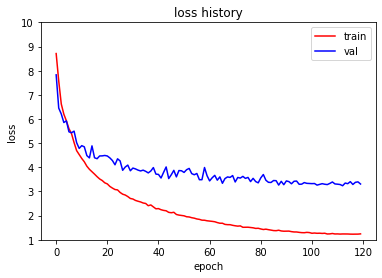

In [8]:
loss_history = torch.load('logs/loss_history.npy')
plt.plot(loss_history['train'], 'r', label='train')
plt.plot(loss_history['val'], 'b', label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss history')
plt.legend()
plt.ylim([1,10])
plt.show()

In [9]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [10]:
# import subprocess
# import time
# time.sleep(3)
# subprocess.Popen(('shutdown', 'now'), stdout=subprocess.PIPE)